In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import itertools
from astropy.io import fits
import scipy
import pymaster as nmt
from planck_util import *

In [3]:
ps = PlanckSpectra()
freq1, freq2 = '143', '143'
split1, split2 = 1, 2

In [4]:
# read masks from dict or disk
mask1 = ps.load_mask(freq1)
mask2 = ps.load_mask(freq2)
map1 = ps.load_map(freq1, split1)
map2 = ps.load_map(freq2, split2)

# deal with missing pixels by using the pixel covariance maps
badpix1 = ps.load_bad_pix(freq1, split1)
badpix2 = ps.load_bad_pix(freq2, split2)
for i in range(3):
    map1[i][badpix1[i]] = 0.0
    mask1[i][badpix1[i]] = 0.0
    map2[i][badpix2[i]] = 0.0
    mask2[i][badpix2[i]] = 0.0

# subtract monopole and dipole
# map1[0] = ps.subtract_mono_di(map1[0], mask1[0], mono_fac=1.1)
# map2[0] = ps.subtract_mono_di(map2[0], mask2[0], mono_fac=1.1)

# map1[1] = ps.subtract_mono_di(map1[1], mask1[1])
# map2[1] = ps.subtract_mono_di(map2[1], mask2[1])
# map1[2] = ps.subtract_mono_di(map1[2], mask1[2])
# map2[2] = ps.subtract_mono_di(map2[2], mask2[2])

# obtain beam
Bl = ps.load_beam(freq1, freq2)

/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


```
fits_out = YES
pixelfile = YES
subdipole = YES
mapfile = ~/silvia/2016_dust/spectra/rd12rc4/maps/100_h1.fits
nlmax = 3100
verbosity = 2
weightfilep2 =
~/silvia/2016_dust/spectra/rd12rc4/masks/combos_manyfsky/COMBO_GALfsky52_DEAD100GHz_QU_HM1_2048.fits
clfile =
~/silvia/2016_dust/spectra/rd12rc4/res_samemasks_Boulanger52/t_52/Cl_100_h1x100_h1.fits
beam_file2 = NO
weightfilep =
~/silvia/2016_dust/spectra/rd12rc4/masks/combos_manyfsky/COMBO_GALfsky52_DEAD100GHz_QU_HM1_2048.fits
polarization = YES
weightfile =
~/silvia/2016_dust/spectra/rd12rc4/masks/combos_manyfsky/COMBO_GALfsky52_DEAD100GHz_I_HM1_2048.fits
decouple = YES
mapfile2 = ~/silvia/2016_dust/spectra/rd12rc4/maps/100_h1.fits
weightfile2 =
~/silvia/2016_dust/spectra/rd12rc4/masks/combos_manyfsky/COMBO_GALfsky52_DEAD100GHz_I_HM1_2048.fits
symmetric_cl = NO
beam_file = NO
```

In [5]:
import ispice

In [6]:
hp.write_map('window1.fits', mask1, overwrite=True)
hp.write_map('window2.fits', mask2, overwrite=True)

hp.write_map('map1.fits', map1, overwrite=True)
hp.write_map('map2.fits', map2, overwrite=True)

In [7]:
ispice.ispice(mapin1='map1.fits', weightfile1='window1.fits',
              mapfile2='map2.fits', weightfile2='window2.fits',
              polarization='YES', symmetric_cl='NO', decouple='YES',
              subdipole='YES', subav='YES', nlmax=3100, tolerance="1.e-6",
              clout='cl.fits')

Submitting job 0
/home/zequnl/Installs/PolSpice_v03-05-01/bin/./spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile cl.fits -decouple YES -mapfile map1.fits -mapfile2 map2.fits -fits_out YES -weightfile window1.fits -weightfile2 window2.fits -nlmax 3100 -normfac 1.00000 -npairsthreshold 0.00000 -overwrite YES -polarization YES -pixelfile YES -pixelfile2 YES -subav YES -subdipole YES -symmetric_cl NO -thetamax NO -tolerance 1.e-6 -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 


0

In [8]:
nside = 2048
pixwin = hp.sphtfunc.pixwin(nside)

In [9]:
def get_Cb(spec):
    
    rawcl = fits.open('cl.fits')[1].data[spec] / Bl[:3101]**2
    
    if spec == 'TE':
        rawcl += fits.open('cl.fits')[1].data['ET'] / Bl[:3101]**2
        rawcl /= 2
    
    binleft, binright = np.genfromtxt('planck_spectra//binused.dat', 
                                              unpack=True, usecols=(0,1), dtype=((int), (int)))

    binleft, binright = binleft, binright
    ells = np.arange(len(rawcl))
    bpws = -1+np.zeros_like(ells) #Array of bandpower indices
    for i, (bl, br) in enumerate(zip(binleft, binright)):
        bpws[bl:br+1] = i

    binned_ell = np.array([ np.sum(ells[bpws==bp])/np.sum(bpws==bp)
                           for bp in range(len(binleft)) ])
    weights = ells * (ells+1)
    Cb_polspice = np.array([ np.sum(
            (rawcl * weights)[bpws==bp])  / np.sum(weights[bpws==bp]) 
                              for bp in range(len(binleft)) ])
    return binned_ell, Cb_polspice

In [10]:
def plotspec(spec):
    binned_ell, Cb_polspice = get_Cb(spec)

    plt.figure(figsize=(12,6))
#     plt.axhline(0, color='red', alpha=0.3)
    plt.ylabel(r'$(D_{\ell}^{\mathrm{polspice}} - D^{\rm nmt}_{\ell}) / \sigma$',fontsize=20)
    plt.xlabel(r'$\ell$',fontsize=20)

    lmin_,lmax_,l,cl,error=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{freq1}x{freq2}' + '.dat',unpack=True)

    plt.plot(l,
             (cl) * l**2 / 2 /np.pi, label='reference')

    plt.plot(binned_ell[:-16],(Cb_polspice*binned_ell**2)[:-16]/(2*np.pi) * 1e12, 'r.', marker='+', label='polspice')
    plt.legend()

    plt.figure(figsize=(12,6))
    plt.axhline(0, color='red', alpha=0.3)
    # plot the fractional difference
    # plt.plot(lb_pspy,(Cb_pspy-Cb_namaster[0][:100])/Cb_namaster[0][:100], label='pspy')
    plt.ylabel(r'$(D_{\ell}^{\mathrm{polspice}} - D^{\rm planck}_{\ell}) / \sigma$',fontsize=20)
    plt.xlabel(r'$\ell$',fontsize=20)

    # plot the fractional difference
    plt.plot(l,
             (Cb_polspice[:-16]*1e12
              -cl) / error, 'k.-', label='polspice')

    plt.ylim(-4, 4)
    plt.legend()

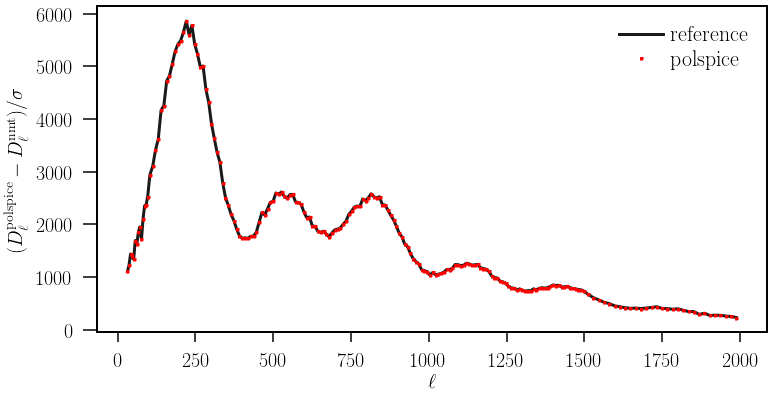

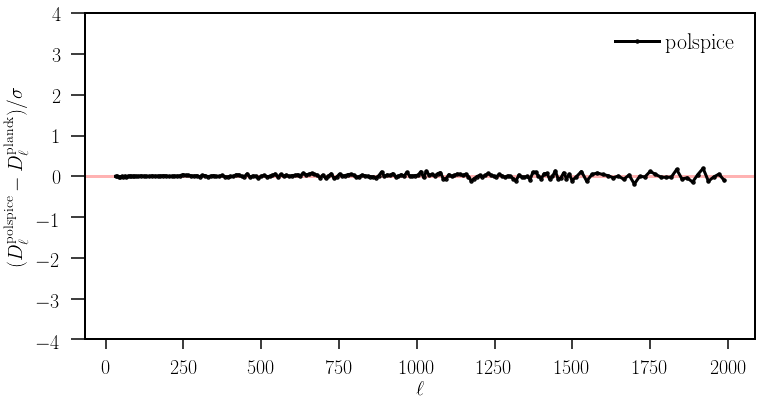

In [15]:
plotspec('TT')

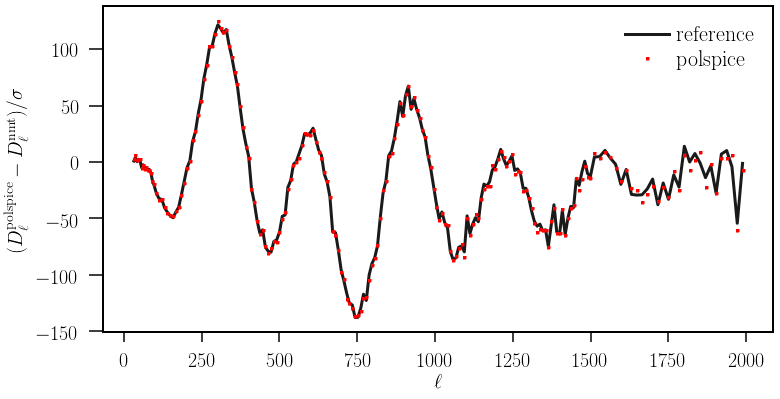

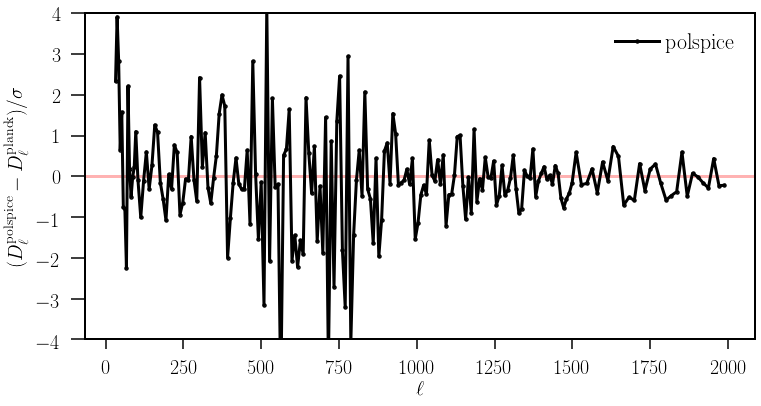

In [16]:
plotspec('TE')

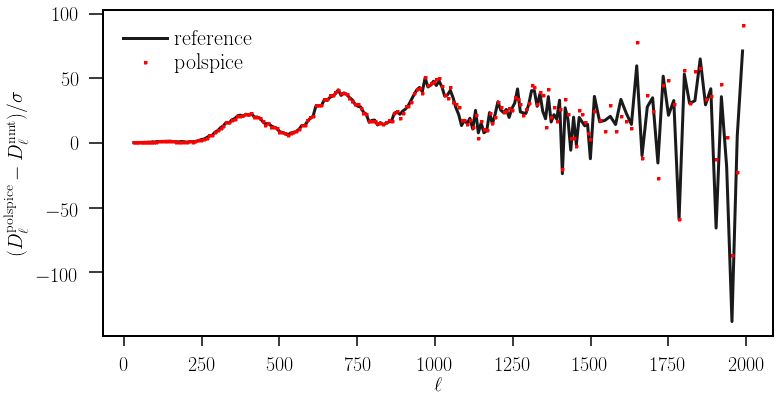

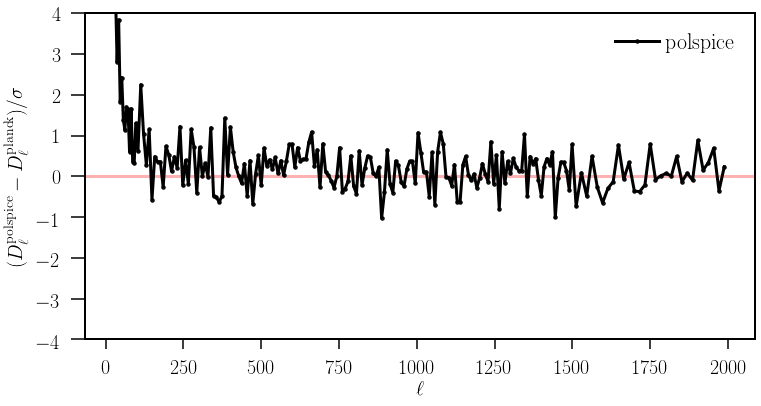

In [17]:
plotspec('EE')